In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import processing
from utils import utils

from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, TimeDistributed
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (18,10)

In [3]:
kld = pd.read_csv('../data/processed/kolding_features.csv', index_col='Datetime', parse_dates=['Datetime'])
stb = pd.read_csv('../data/processed/kolding_features.csv', index_col='Datetime', parse_dates=['Datetime'])

In [4]:
# Processing Parameters
split = 0.80 # split percentage for training data
steps = 1 # timesteps: 1 hour

lookback = 24 * 7 # the number of hours in the past the model is shown
horizon = 1 # the target hour in the future we want to predict 1 hour ahead

# Training parameters
batch_size = 256
epochs = 50
lr = 0.001

In [5]:
# Create Train, Val, and Test Sets
kld_train, kld_val, kld_test = processing.create_datasets(kld, split=split, steps=steps, lookback=lookback,
                                                          horizon=horizon, batch_size=batch_size, scaler='standard')
stb_train, stb_val, stb_test = processing.create_datasets(stb, split=split, steps=steps, lookback=lookback,
                                                          horizon=horizon, batch_size=batch_size, scaler='standard')

In [6]:
for batch in kld_train.take(1):
    inputs, targets = batch
    
print(f"Input Shape: {inputs.numpy().shape}")
print(f"Target Shape: {targets.numpy().shape}")

Input Shape: (256, 168, 7)
Target Shape: (256, 1)


In [17]:
hybrid = Sequential()

hybrid.add(Input(shape=(inputs.shape[1], inputs.shape[2])))

hybrid.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
hybrid.add(MaxPooling1D(pool_size=2))
hybrid.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
hybrid.add(MaxPooling1D(pool_size=2))

hybrid.add(LSTM(64, return_sequences=True))
hybrid.add(Dropout(0.25))
hybrid.add(LSTM(128, return_sequences=True))
hybrid.add(Dropout(0.25))

hybrid.add(GRU(64, return_sequences=True))
hybrid.add(Dropout(0.25))
hybrid.add(GRU(128, return_sequences=False))
hybrid.add(Dropout(0.25))

hybrid.add(Dense(1))

hybrid.compile(optimizer=Adam(learning_rate=lr), loss="mse")



In [18]:
hybrid.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 167, 64)           960       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 83, 64)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 82, 128)           16512     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 41, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 41, 64)            49408     
_________________________________________________________________
dropout_8 (Dropout)          (None, 41, 64)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 41, 128)          

In [12]:
# Callbacks
ckpt_path = "../model/models/hybrid_base.h5"
estp = EarlyStopping(monitor='val_loss', patience=10)

ckpt = ModelCheckpoint(
    monitor='val_loss',
    filepath=ckpt_path,
    verbose=1,
    save_weights_only=True,
    save_best_only=True
)

In [13]:
history = hybrid.fit(
    kld_train,
    epochs=epochs,
    validation_data=kld_val,
    callbacks=[estp, ckpt]
)

Epoch 1/50
60/60 [==============================] - 32s 418ms/step - loss: 0.9722 - val_loss: 1.5801

Epoch 00001: val_loss improved from inf to 1.58010, saving model to ../model/models\hybrid_base.h5
Epoch 2/50
60/60 [==============================] - 23s 377ms/step - loss: 1.1325 - val_loss: 1.8240

Epoch 00002: val_loss did not improve from 1.58010
Epoch 3/50
60/60 [==============================] - 23s 382ms/step - loss: 1.2476 - val_loss: 1.6656

Epoch 00003: val_loss did not improve from 1.58010
Epoch 4/50
60/60 [==============================] - 23s 383ms/step - loss: 1.1495 - val_loss: 1.4450

Epoch 00004: val_loss improved from 1.58010 to 1.44504, saving model to ../model/models\hybrid_base.h5
Epoch 5/50
60/60 [==============================] - 23s 388ms/step - loss: 0.9687 - val_loss: 1.3225

Epoch 00005: val_loss improved from 1.44504 to 1.32249, saving model to ../model/models\hybrid_base.h5
Epoch 6/50
60/60 [==============================] - 23s 389ms/step - loss: 0.9091 -

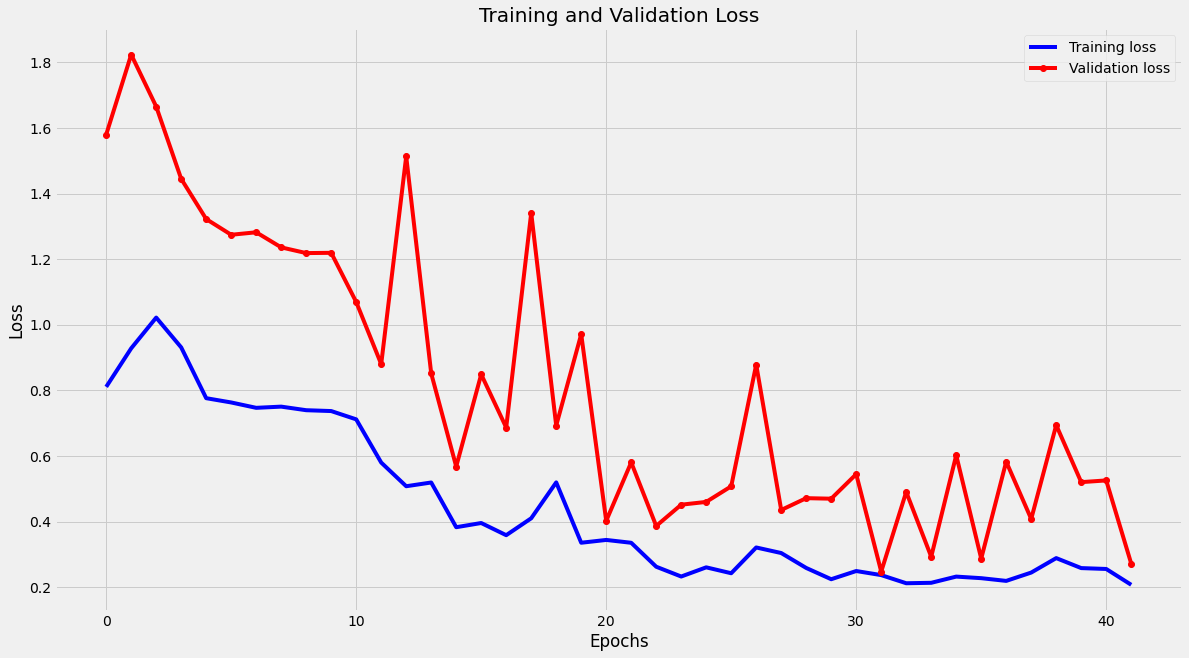

In [14]:
utils.plot_training(history, "Training and Validation Loss")

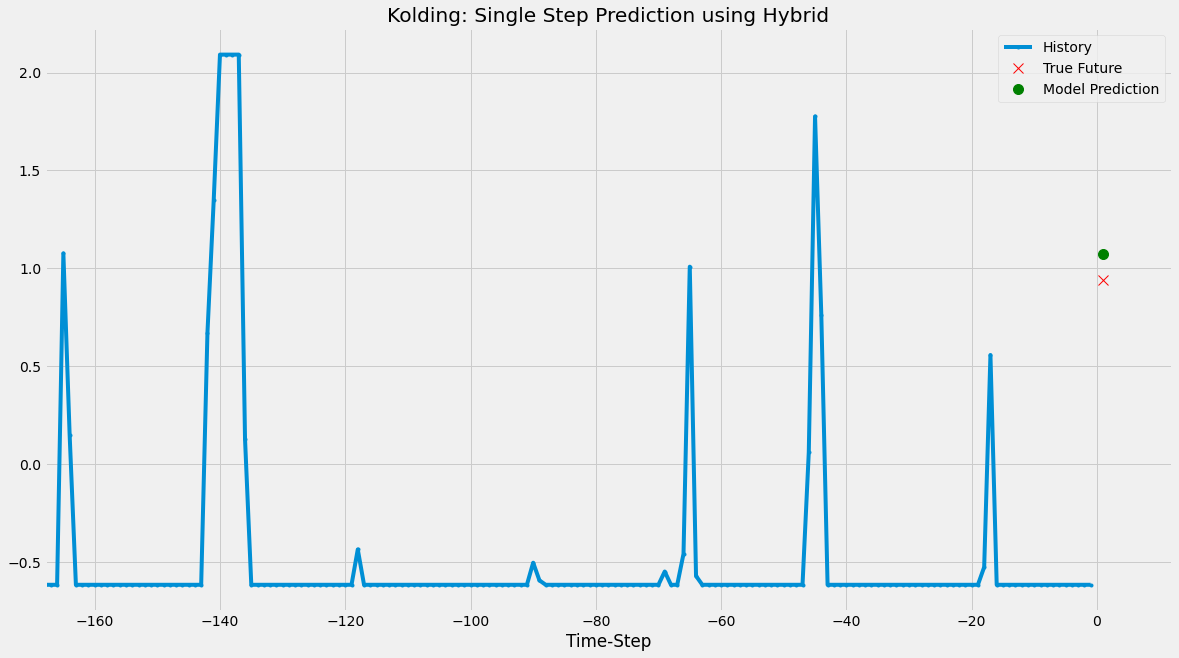

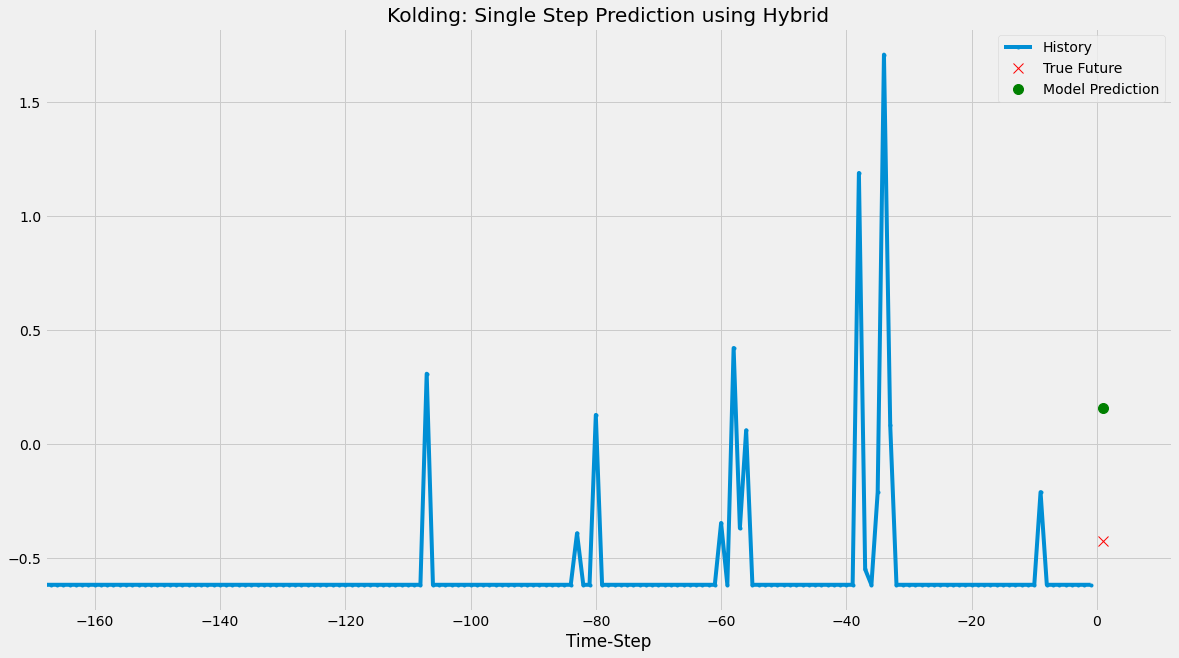

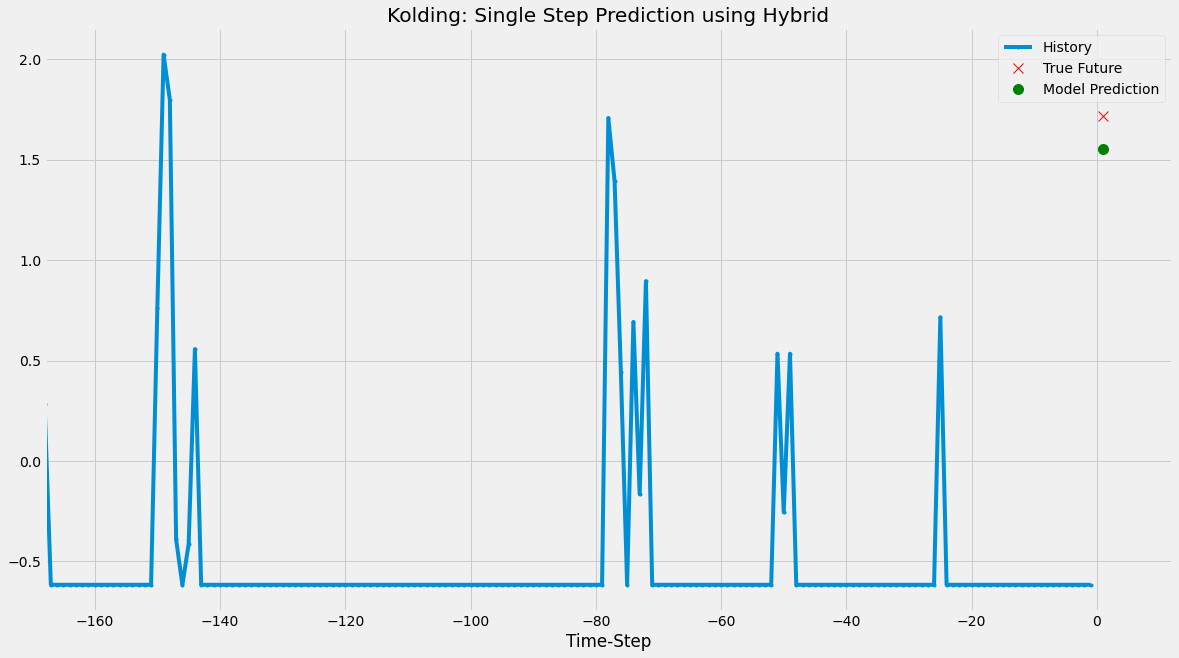

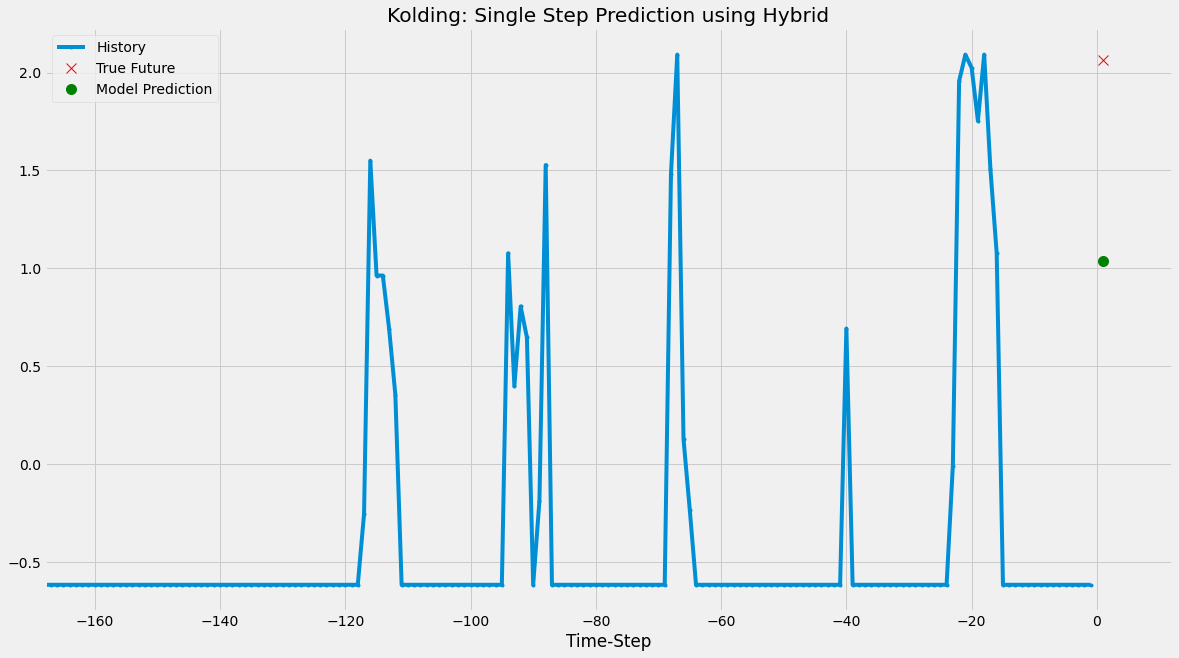

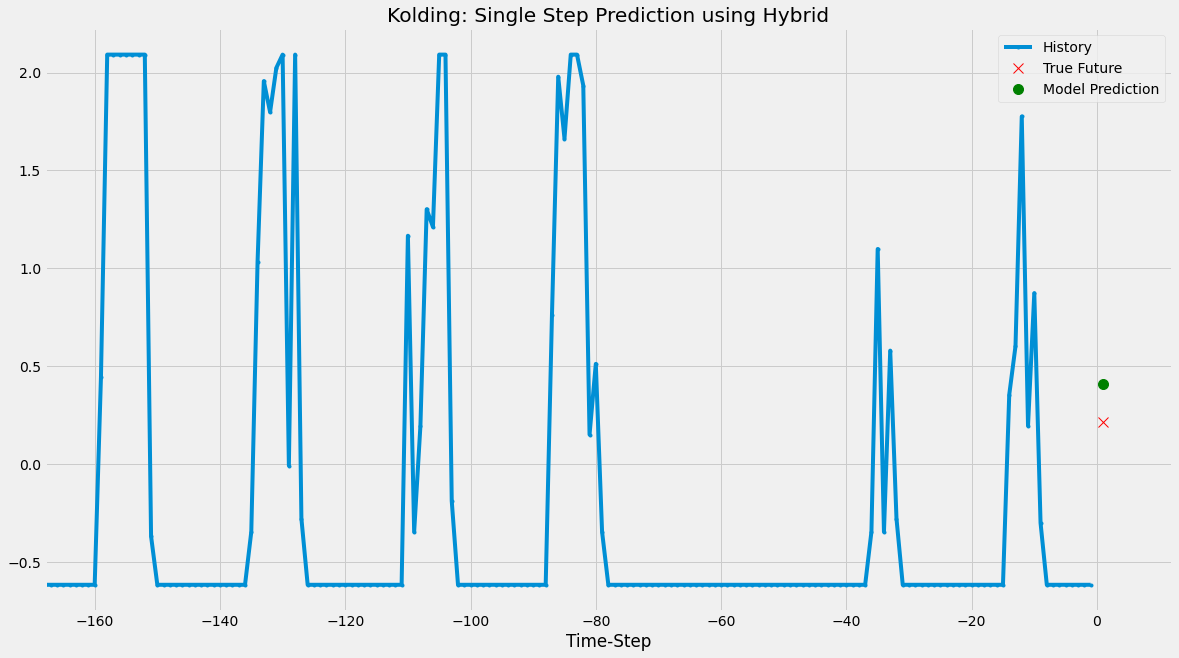

In [15]:
# Predictions
for x, y in kld_test.take(5):
    utils.plot_pred(
        [x[0][:, 1].numpy(), y[0].numpy(), hybrid.predict(x)[0]],
        1,
        "Kolding: Single Step Prediction using Hybrid CNN-LSTM",
    )


In [14]:
hybrid = Sequential()

hybrid.add(Input(shape=(inputs.shape[1], inputs.shape[2])))

hybrid.add(LSTM(64, return_sequences=True))
hybrid.add(Dropout(0.25))
hybrid.add(LSTM(128, return_sequences=True))
hybrid.add(Dropout(0.25))

hybrid.add(GRU(64, return_sequences=True))
hybrid.add(Dropout(0.25))
hybrid.add(GRU(128, return_sequences=True))
hybrid.add(Dropout(0.25))

hybrid.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
hybrid.add(MaxPooling1D(pool_size=2))
hybrid.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
hybrid.add(MaxPooling1D(pool_size=2))
hybrid.add(Flatten())

hybrid.add(Dense(64, activation='relu'))
hybrid.add(Dropout(0.25))
hybrid.add(Dense(1))

hybrid.compile(optimizer=Adam(learning_rate=lr), loss="mse")

In [16]:
hybrid.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 168, 64)           18432     
_________________________________________________________________
dropout (Dropout)            (None, 168, 64)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 168, 128)          98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 168, 128)          0         
_________________________________________________________________
gru (GRU)                    (None, 168, 64)           37248     
_________________________________________________________________
dropout_2 (Dropout)          (None, 168, 64)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 168, 128)         

In [17]:
# Callbacks
ckpt_path = "../model/models/lstmgrucnn_base.h5"
estp = EarlyStopping(monitor='val_loss', patience=10)

ckpt = ModelCheckpoint(
    monitor='val_loss',
    filepath=ckpt_path,
    verbose=1,
    save_weights_only=True,
    save_best_only=True
)

In [18]:
history = hybrid.fit(
    kld_train,
    epochs=epochs,
    validation_data=kld_val,
    callbacks=[estp, ckpt]
)

Epoch 1/50
60/60 [==============================] - 133s 2s/step - loss: 0.8047 - val_loss: 1.2563

Epoch 00001: val_loss improved from inf to 1.25627, saving model to ../model/models\lstmgrucnn_base.h5
Epoch 2/50
60/60 [==============================] - 139s 2s/step - loss: 0.7589 - val_loss: 1.1061

Epoch 00002: val_loss improved from 1.25627 to 1.10610, saving model to ../model/models\lstmgrucnn_base.h5
Epoch 3/50
60/60 [==============================] - 149s 2s/step - loss: 0.6772 - val_loss: 0.7823

Epoch 00003: val_loss improved from 1.10610 to 0.78233, saving model to ../model/models\lstmgrucnn_base.h5
Epoch 4/50
60/60 [==============================] - 159s 3s/step - loss: 0.5211 - val_loss: 1.1791

Epoch 00004: val_loss did not improve from 0.78233
Epoch 5/50
60/60 [==============================] - 169s 3s/step - loss: 0.5005 - val_loss: 0.6659

Epoch 00005: val_loss improved from 0.78233 to 0.66590, saving model to ../model/models\lstmgrucnn_base.h5
Epoch 6/50
60/60 [=======

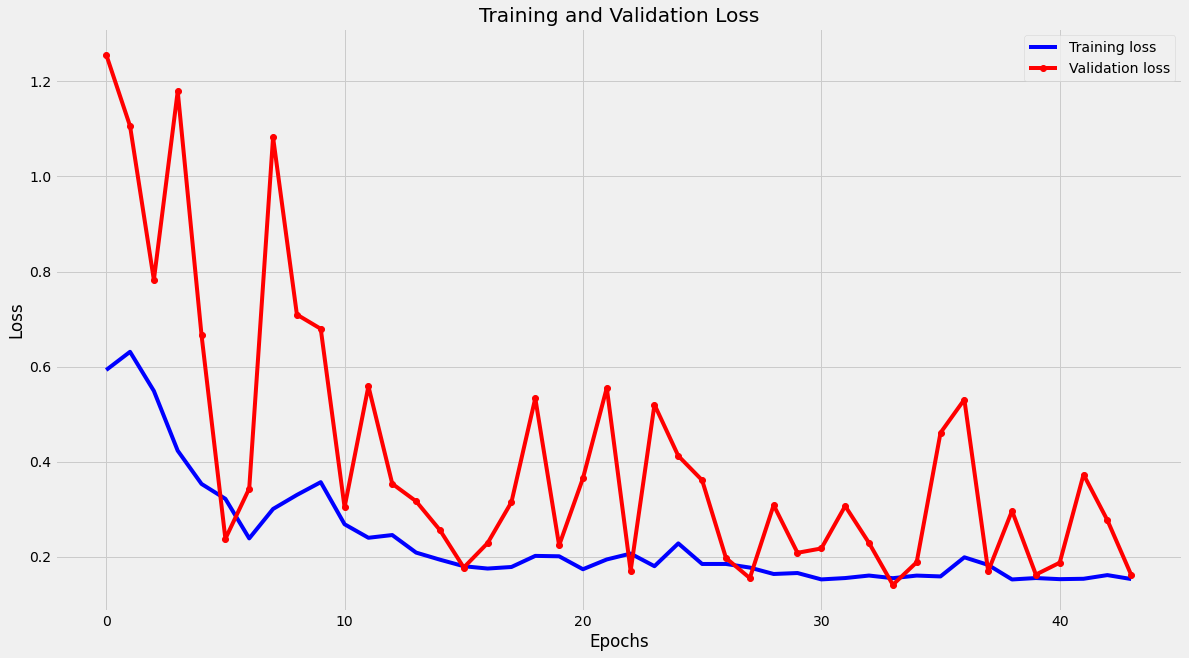

In [19]:
utils.plot_training(history, "Training and Validation Loss")

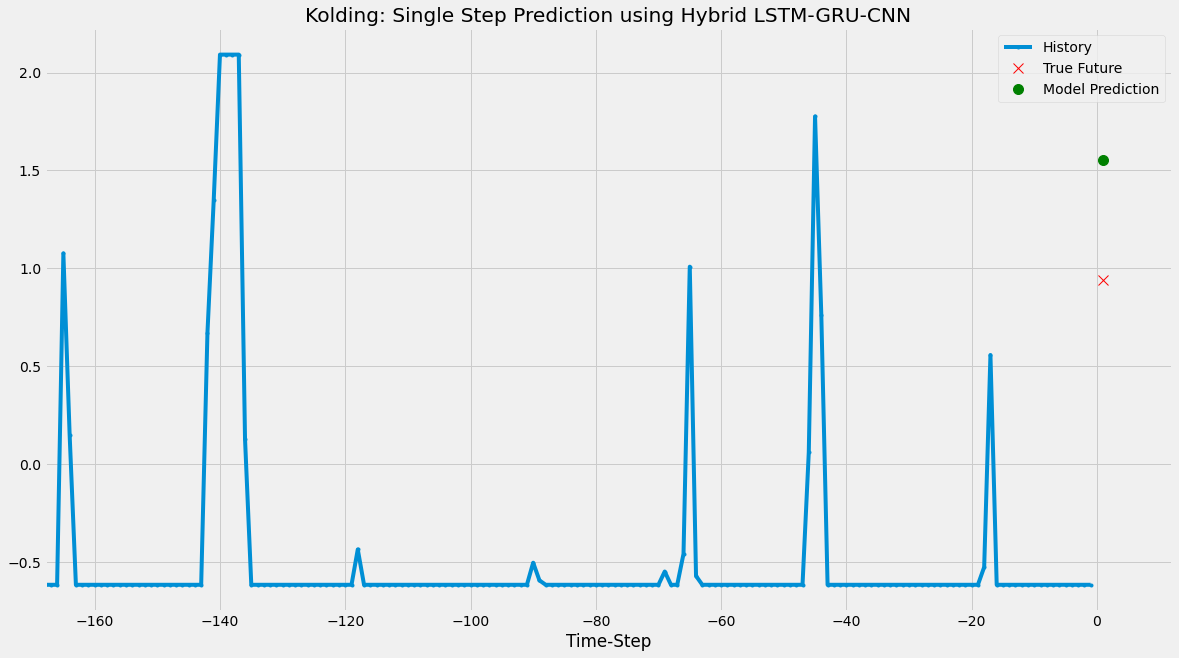

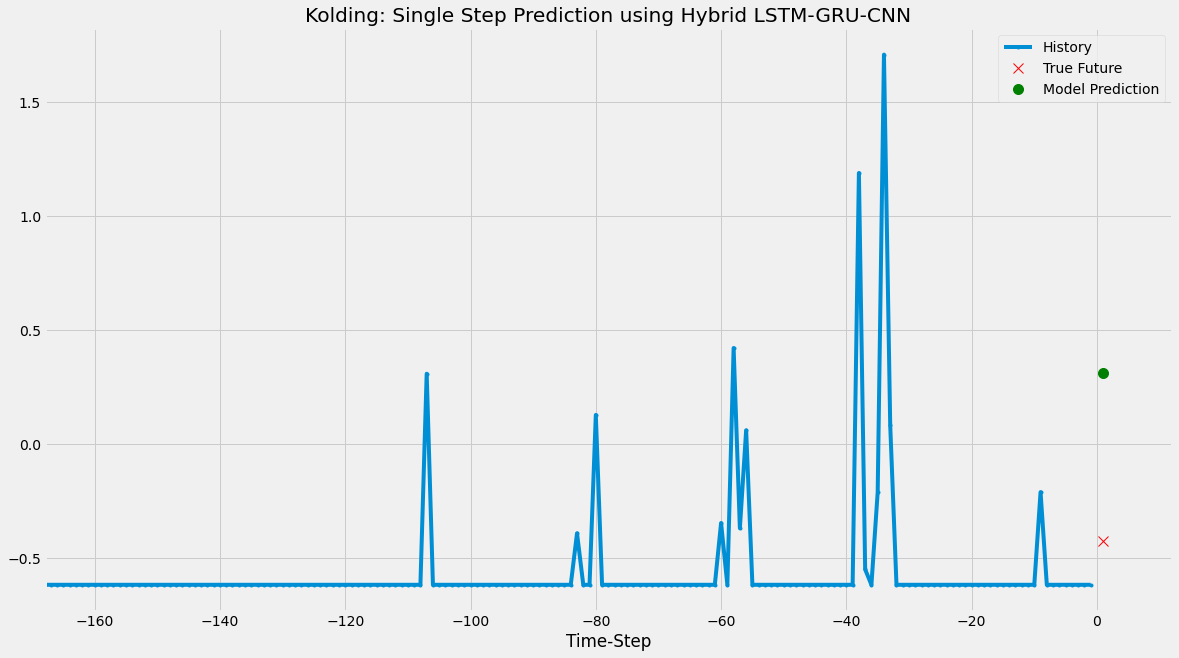

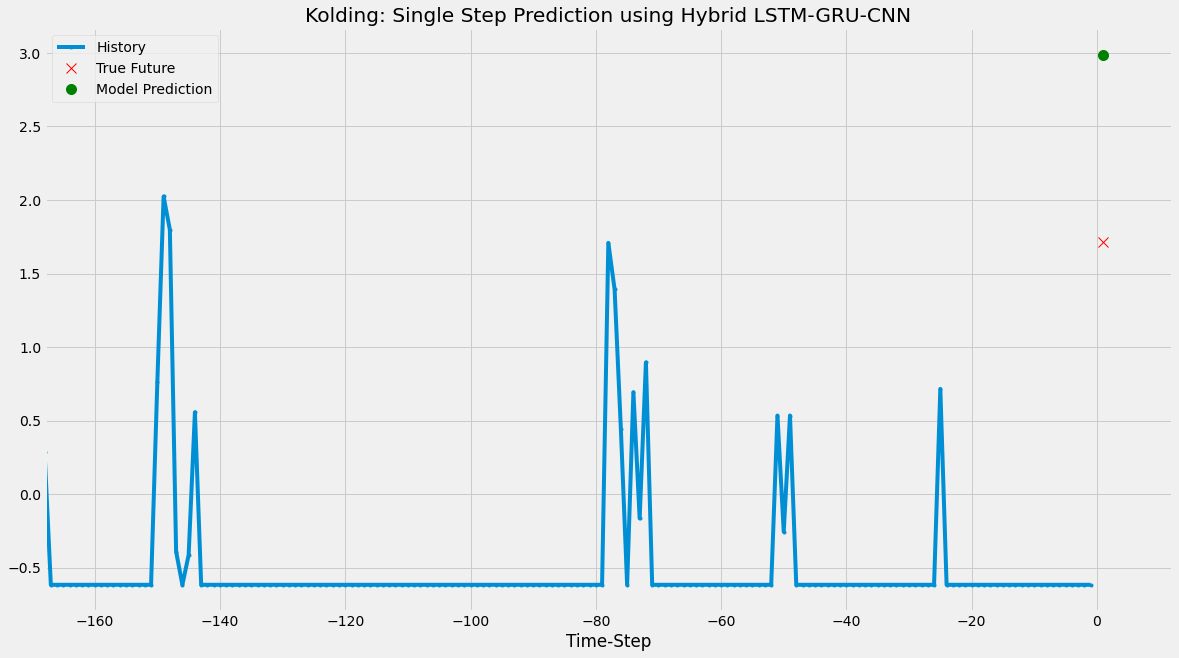

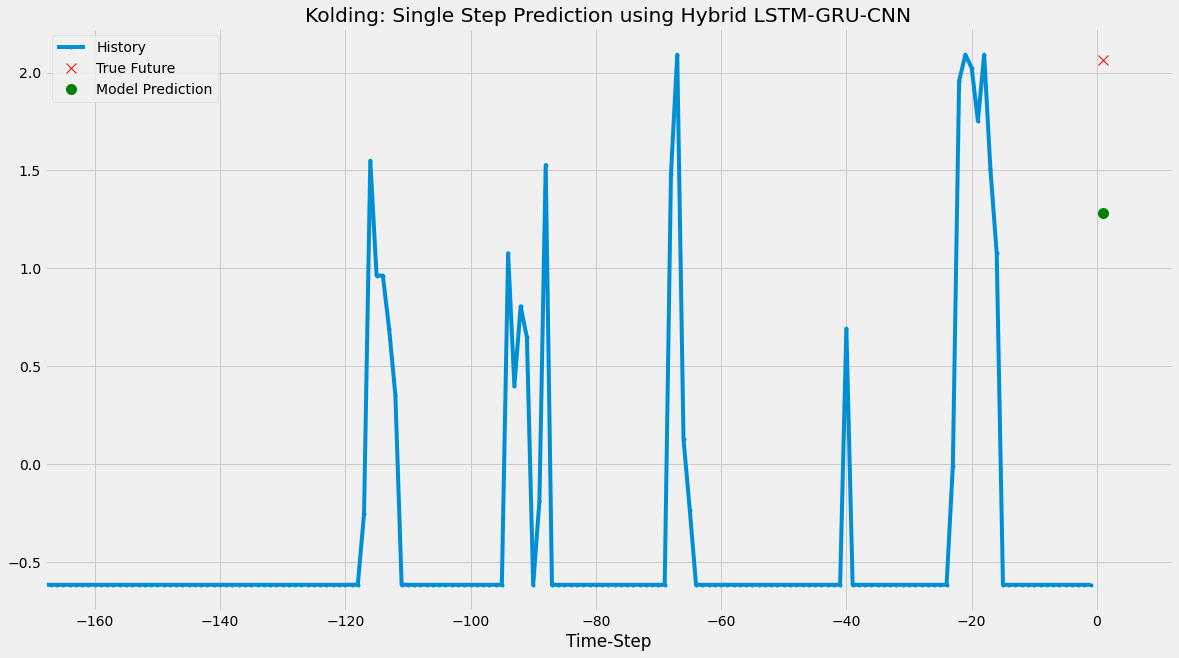

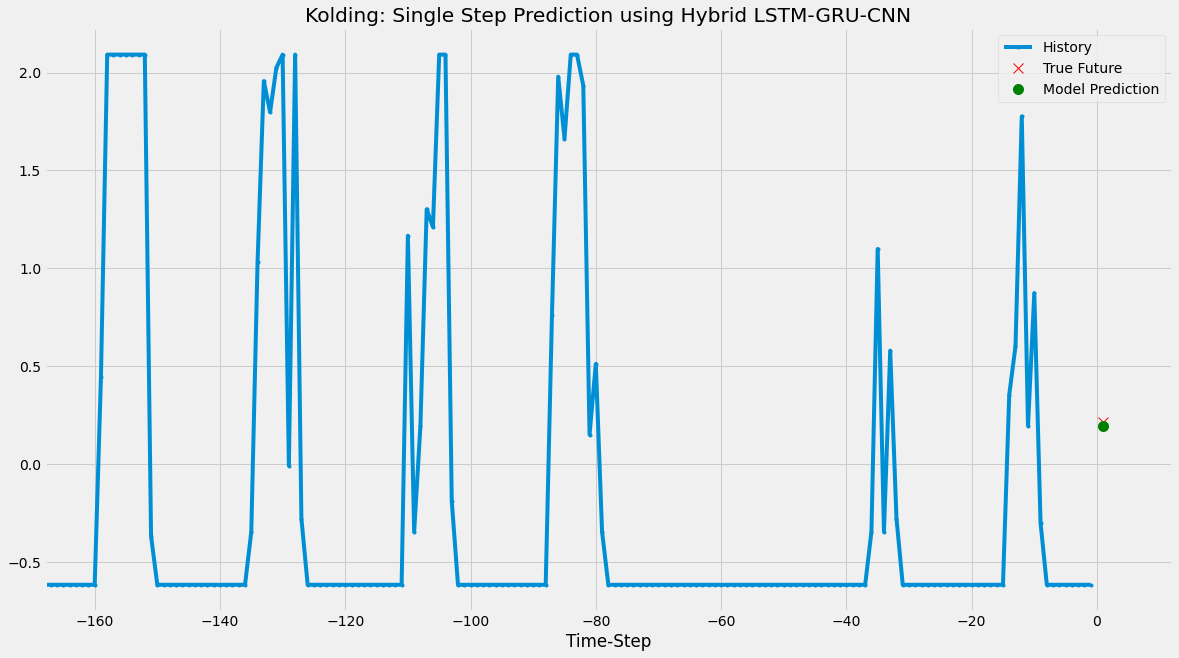

In [20]:
# Predictions
for x, y in kld_test.take(5):
    utils.plot_pred(
        [x[0][:, 1].numpy(), y[0].numpy(), hybrid.predict(x)[0]],
        1,
        "Kolding: Single Step Prediction using Hybrid LSTM-GRU-CNN",
    )
